In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# pre-processing
def preprocess(phrases):
  processed_phrases = []
  for s in range(0, len(phrases)):
    # remove tags
    processed = re.sub(r'<.*?>', ' ', str(phrases[s]))
    # remove special characters
    processed = re.sub(r'[^a-zA-Z0-9]',' ',processed)
    # remove extra spaces
    processed = re.sub(r'\s+', ' ', processed, flags=re.I)
    # remove numbers 
    processed = re.sub(r'\w*\d\w*', '', processed)
    # to lowercase
    processed = processed.lower()
    processed_phrases.append(processed)
  return processed_phrases


In [ ]:
# Bag-of-words features
from sklearn.feature_extraction.text import CountVectorizer
def get_features(train_phrase, dev_phrase, test_phrase):
  count_vec = CountVectorizer()
  count_vec.fit(train_phrase)
  print("Vocabulary size: %d" % len(count_vec.get_feature_names()))
  x_train = count_vec.transform(train_phrase)
  x_dev = count_vec.transform(dev_phrase)
  x_test = count_vec.transform(test_phrase)
  return x_train, x_dev, x_test

In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/MyDrive/df_train.csv', sep=",")
test = pd.read_csv('/content/drive/MyDrive/df_dev.csv', sep=",")
dev = pd.read_csv('/content/drive/MyDrive/df_dev.csv', sep=",")

Mounted at /content/drive


In [ ]:
train.head(10)

,Unnamed: 0,PhraseId,SentenceId,Phrase,Sentiment
0,25259,25260,1153,gold,3
1,101894,101895,5363,you could change tables,3
2,12380,12381,530,of the best films of the year,4
3,13188,13189,566,sustain it,2
4,79711,79712,4104,stunning star turn,4
5,126318,126319,6790,", Laissez-passer has all the earmarks of Frenc...",4
6,114213,114214,6073,Merry,3
7,95446,95447,4985,... ` The Country Bears ' should never have be...,1
8,111084,111085,5887,the failure of the third Revenge of the Nerds ...,1
9,137364,137365,7432,use of his particular talents,3


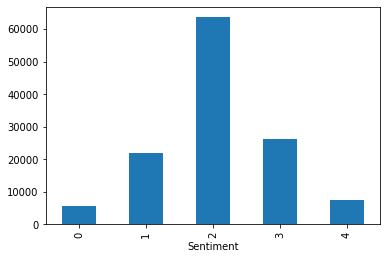

In [ ]:
train.groupby('Sentiment').Phrase.count().plot.bar()

In [ ]:
cleaned_train = preprocess(train['Phrase'])
cleaned_dev = preprocess(dev['Phrase'])
cleaned_test = preprocess(test['Phrase'])

# get features
x_train, x_dev, x_test = get_features(cleaned_train, cleaned_dev, cleaned_test)

# labels
y_train = train['Sentiment']
y_dev = dev['Sentiment']

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Vocabulary size: 15082


In [ ]:
def find_best_C(x_train, y_train, x_dev, y_dev, C_vals):
  # find the best C from C_vals using the development data
  best_acc = 0.
  best_c = 0.
  accuracy = []
  for c in C_vals:
    lr = LogisticRegression(C=c,multi_class='auto', solver='liblinear')
    lr.fit(x_train, y_train)
    cur_acc = accuracy_score(y_dev, lr.predict(x_dev))
    print ("Accuracy for C = %s: %s" % (c, cur_acc))
    accuracy.append(cur_acc)
    if cur_acc > best_acc:
      best_c = c
      best_acc = cur_acc
  
  print("Best accuracy = %f, best C = %f" % (best_acc, best_c))
  plt.plot(np.array(C_vals).astype('str'), accuracy, 'ro')
  return best_c


Accuracy for C = 0.1: 0.5983916442393951
Accuracy for C = 0.3: 0.6200179418172498
Accuracy for C = 0.5: 0.6281237985390234
Accuracy for C = 0.7: 0.632320902217096
Accuracy for C = 0.9: 0.6350442137639369
Accuracy for C = 1.1: 0.6372549019607843
Accuracy for C = 1.5: 0.6392092784826349
Accuracy for C = 2.0: 0.6411316160451108
Accuracy for C = 2.5: 0.6419966679482251
Accuracy for C = 3.0: 0.6419966679482251
Best accuracy = 0.641997, best C = 2.500000


2.5

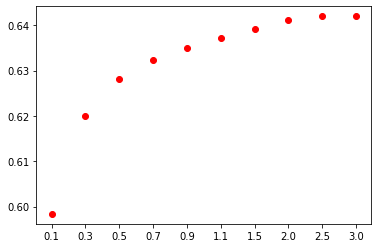

In [ ]:
C_vals = [0.10, 0.3, 0.5, 0.7, 0.9, 1.1, 1.5, 2.0, 2.5, 3.0]
best_c = find_best_C(x_train, y_train, x_dev, y_dev, C_vals)
best_c

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy is 0.7107282455465846
Confusion Matrix



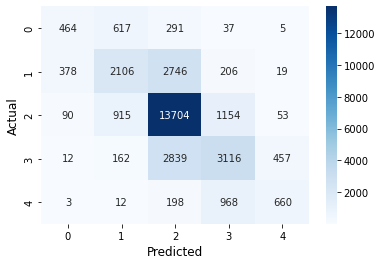


Classification Metrics

              precision    recall  f1-score   support

           0       0.49      0.33      0.39      1414
           1       0.55      0.39      0.45      5455
           2       0.69      0.86      0.77     15916
           3       0.57      0.47      0.52      6586
           4       0.55      0.36      0.43      1841

    accuracy                           0.64     31212
   macro avg       0.57      0.48      0.51     31212
weighted avg       0.62      0.64      0.62     31212



In [ ]:
# Evaluate on the development data
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

lr_clf = LogisticRegression(C=best_c)
lr_clf.fit(x_train, y_train)
y_pred = lr_clf.predict(x_dev)

# save
pd.DataFrame(y_pred).to_csv('lr_dev_pred.csv', sep='\t', encoding='utf-8')

# training accuracy
print("The training accuracy is {}".format(lr_clf.score(x_train, y_train)))

# Calculate and plot confusion matrix
cf_matrix = confusion_matrix(y_dev, y_pred)

print("Confusion Matrix\n")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

# Report classification metrics
lr_report = classification_report(y_dev, y_pred)

print("\nClassification Metrics\n")
print(lr_report)

In [ ]:
# sample output
def get_sample(n):
  """
  Return n samples of phrases, true sentiment labels and predictions on development data 
  """
  dev_sample = dev[['Phrase','Sentiment']].copy()
  dev_sample['prediction'] = y_pred
  display(dev_sample.sample(n=n))
get_sample(5)

,Phrase,Sentiment,prediction
3019,becomes claustrophobic,1,1
25062,transparently hypocritical work,1,1
4341,"Sodden and glum , even in those moments where ...",1,1
22202,"the script , which has a handful of smart jokes",3,3
4037,a little too familiar,1,2


In [ ]:
# predict on test data
y_pred_test = lr_clf.predict(x_test)